In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 라이브러리

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers  

# !pip install konlpy
# from konlpy.tag import Kkma
# tokenizer = Kkma()

from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.utils import *
from sklearn.model_selection import train_test_split

In [ ]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import numpy as np
import pandas as pd

In [ ]:
!pip install -q wordcloud

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import itertools


# 데이터셋 만들기

## 문장 전처리 함수

In [ ]:
nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))
stop_words.extend(["'m"])
print()
temp = ['hadn','mightn','mustn','wasn','couldn','doesn','hasn','ain','shan','aren','weren','wouldn','shouldn']
new_temp = []
for t in temp:
  new_temp.append(t+'t')
new_stopwords = ["i'm","i've","ive"] + new_temp

for word in stop_words:
    if 'not' in word: continue
    elif "'t" in word: continue
    elif len(word) == 1: continue
    elif word in temp: continue
    elif '!' in word: continue
    elif '.' in word: continue
    else: new_stopwords.append(word)
        
## 감정분석용 cleansing
def s_cleansing(List):
    count=0
    corpus = []
    for i in List:
        i = str(i)# 정규화 에러로 인해 추가
        url_pattern ='https?://\S+|#([0-9a-zA-Z]*)'
        i = re.sub(pattern=url_pattern, repl=' ', string = i)
        i = i.replace('\r','').replace('\n','')
        text = re.sub('[-=+,#/\?:^$”@*\"“※~&%ㆍ!』\\‘|\(\)\[\]\<\>`…》;’]', '', i.lower())
        corpus.append(text)
        count+=1
        #if(count>24900): print(count)        
    return corpus



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## 불용어 정의 
nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))

STOP_WORDS = set()

file = open("/content/drive/Shareddrives/SWC_Capstone/5월/stopwords.txt", "r")
while True:
    line = file.readline()
    if not line:
        break
    STOP_WORDS.add(line.strip())

file.close()
len(STOP_WORDS)

for word in new_stopwords:
    if word not in STOP_WORDS:
        STOP_WORDS.add(word)
print(STOP_WORDS)

In [ ]:
def tokenize_sentence(text_data):
  result_data = []
  for sentence in (text_data):
    tokenized = text_to_word_sequence(sentence)
        
    token_without_stop = []
    for token in tokenized:
      if token not in STOP_WORDS:
        token_without_stop.append(token)

    result_data.append(token_without_stop)
  return result_data

## 문장 데이터셋 만들기

In [ ]:
names = ['depression', 'bipolar', 'panic', 'covid19', 'relationship', 'teaching',\
        'healthanxiety', 'lonely', 'socialanxiety', 'SuicideWatch', 'mentalhealth', 'conspiracy', 'divorce', 'fitness',\
        'guns', 'jokes', 'legaladvice', 'meditation', 'personalfinance']

MENTAL = "depression / bipolar / panic / healthanxiety / lonely / socialanxiety / SuicideWatch / mentalhealth"
MENTAL = MENTAL.split(" / ")
NONMENTAL = "relationship / teaching / conspiracy / divorce / fitness / guns / jokes / legaladvice / meditation / personalfinance"
NONMENTAL = NONMENTAL.split(" / ")
ENVIRONMENT = ["covid19"]

In [ ]:
# 문장이 있는 데이터셋 불러오기
subreddits = []
for i in range(len(names)):
  temp = pd.read_csv("./"+names[i]+"_sample_ym.csv")
  subreddits.append(temp)

In [ ]:
tot_mix = []

for i in range(len(names)):
  temp_mix = []
  temp = subreddits[i]

  for text in (temp['title'] + ' ' + temp['text_context']):
    temp_mix.append(text)

  tot_mix.append(temp_mix)


print(len(tot_mix))

19


In [ ]:
#라벨링 되어있는 데이터셋으로 구성 (대조군은 하나의 데이터셋으로)
TM_DF = []
TNM_DF = pd.DataFrame()

for i in range(len(names)):
  if names[i] in MENTAL:
    temp = pd.DataFrame()
    temp['train_text'] = tot_mix[i]
    temp['label'] = [names[i] for j in range(len(temp))]
    TM_DF.append(temp[['train_text','label']])
  else:
    temp = pd.DataFrame()
    temp['train_text'] = tot_mix[i]
    temp['label'] = ['nonmental' for j in range(len(temp))]
    TNM_DF = pd.concat([TNM_DF,temp])
    TNM_DF.reset_index(inplace=True, drop=True)

In [ ]:
# 파일 저장
for i in range(len(TM_DF)):
  file_name = 'text_'+MENTAL[i] + '.csv'
  TM_DF[i].to_csv('/content/drive/Shareddrives/SWC_Capstone/5월/classification_dataset/' + file_name, mode='w',index=False)

TNM_DF.to_csv('/content/drive/Shareddrives/SWC_Capstone/5월/classification_dataset/text_nonmental.csv', mode='w',index=False)

In [ ]:
TNM_DF['label'].values

array(['nonmental', 'nonmental', 'nonmental', ..., 'nonmental',
       'nonmental', 'nonmental'], dtype=object)

## 점수 데이터셋 만들기

In [ ]:
all_score = pd.read_csv('/content/drive/Shareddrives/sample/scoring_result_all.csv')

In [ ]:
# # selected columns
all_score.columns
all_score = all_score[['VATokenNum','CITokenNum','avgNV', 'avgPV', 'avgNA', 'avgPA', 'fear', 'trust',\
                       'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4','Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9','subreddit']]
all_score.columns = ['VATokenNum','CITokenNum','avgNV', 'avgPV', 'avgNA', 'avgPA', 'fear', 'trust',\
                     'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4','Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9',\
                     'label']
all_score.head()

# # all columns
# all_score.columns
# all_score = all_score[['avgNV', 'avgPV', 'avgNA', 'avgPA', \
#                        'anger','anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise','trust',\
#                        'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4','Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9','subreddit']]
# all_score.columns = ['avgNV', 'avgPV', 'avgNA', 'avgPA', \
#                      'anger','anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise','trust',\
#                      'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4','Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9',\
#                      'label']
# all_score.head()

,avgNV,avgPV,avgNA,avgPA,fear,trust,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,label
0,0.311591,0.725146,0.341151,0.772207,0.232505,0.153318,0.0,0.0,0.0,0.0,0.000000,0.000000,0.980850,0.000000,0.0,0.00000,depression
1,0.467430,0.701858,0.439104,0.753134,0.126679,0.163459,0.0,0.0,0.0,0.0,0.000000,0.963459,0.021156,0.000000,0.0,0.00000,depression
2,0.423277,0.578681,0.428566,0.597171,0.152800,0.278455,0.0,0.0,0.0,0.0,0.000000,0.000000,0.989534,0.000000,0.0,0.00000,depression
3,0.498657,0.687808,0.495782,0.729708,0.110959,0.253489,0.0,0.0,0.0,0.0,0.027438,0.000000,0.010016,0.000000,0.0,0.95624,depression
4,0.484432,0.581172,0.495972,0.616353,0.128111,0.077288,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012758,0.977014,0.0,0.00000,depression


In [ ]:
score_df_lst = []
index1 = 0
index2 = 0
for i in range(len(names)):
  index2 = len(subreddits[i])
  temp = all_score[all_score['label']==names[i]]
  score_df_lst.append(temp)

print([len(df) for df in score_df_lst])

[3000, 3000, 760, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]


In [ ]:
#라벨링 되어있는 데이터셋으로 구성 (대조군은 하나의 데이터셋으로)
SM_DF = []
SNM_DF = pd.DataFrame()

for i in range(len(names)):
  if names[i] in MENTAL:
    temp = score_df_lst[i]
    SM_DF.append(temp)
  else:
    temp = score_df_lst[i]
    temp['label'] = ['nonmental' for j in range(len(temp))]
    SNM_DF = pd.concat([SNM_DF,temp])
    SNM_DF.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


# 1. 문장 학습 모델

## (1) LSTM

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import itertools

# confusion matrix 그리는 함수 
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}'.format(con_mat[i, j]), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



In [ ]:
def returnXY(df_name):
    if df_name in NONMENTAL:
        print('wrong df. put mental health data')
        return
    index = MENTAL.index(df_name)

    temp = pd.concat([TNM_DF,TM_DF[index]])

    y= pd.get_dummies(temp['label'].values).values
  
  
    return temp['train_text'].values, y

def returnXY_mult():
    temp = pd.concat([df for df in TM_DF])
    temp = pd.concat([temp,TNM_DF])

    y= pd.get_dummies(temp['label'].values).values
  
  
    return temp['train_text'].values, y

In [ ]:
def LSTM_binary(df_name,save_path):
    X_final,y_final = returnXY(df_name)
    print(df_name, '-->', MENTAL.index(df_name))
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, shuffle=True, stratify=y_final)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    count = 0
    for word, word_count in tokenizer.word_counts.items():
        if word_count > 1:
            count += 1
    print(count)

    vocab_size = count #####
    tokenizer = Tokenizer(vocab_size)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    print("# int_encoding done")
    max_len = 100
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)

    embedding_dim = 100
    hidden_units = 128
    num_classes = 2

    # 모델 구축
    # 레이어들을 쌓을 모델을 생성
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='sigmoid'))

    early_stop = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=3)
    model_check = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=16, callbacks=[early_stop, model_check])

    loaded_model = load_model(save_path)
    print("테스트 정확도 : %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

    epochs = range(1, len(hist.history['acc']) + 1)
    plt.plot(epochs, hist.history['loss'])
    plt.plot(epochs, hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(epochs, hist.history['acc'])
    plt.plot(epochs, hist.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = loaded_model.predict(X_test)
    labels = ['mental', 'nonmental']
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        else:
            y_.append(1)
    true_labels = y_

    #precision
    print(df_name)
    print("--> precision_score : ", precision_score(true_labels, pred_labels, average="weighted"))

    #recall

    print("--> recall_score : ", recall_score(true_labels, pred_labels, average="weighted"))

    #f1scord

    print("---> f1_score : ", f1_score(true_labels, pred_labels, average="weighted"))


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding, Dropout


def LSTM_multi(save_path,epoch):
    X_final,y_final = returnXY_mult()
    # print(df_name, '-->', MENTAL.index(df_name))
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, shuffle=True, stratify=y_final)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    count = 0

    for word, word_count in tokenizer.word_counts.items():
        if word_count > 1:
            count += 1
    print(count)

    vocab_size = count #####
    tokenizer = Tokenizer(vocab_size)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    print("# int_encoding done")
    max_len = 100
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)

    
    embedding_dim = 100
    hidden_units = 128
    num_classes = 9

    # 모델 구축
    # 레이어들을 쌓을 모델을 생성
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))


    early_stop = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=3)
    model_check = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch, batch_size=16, callbacks=[early_stop, model_check])

    loaded_model = load_model(save_path)
    print("테스트 정확도 : %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

    epochs = range(1, len(hist.history['acc']) + 1)
    plt.plot(epochs, hist.history['loss'])
    plt.plot(epochs, hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(epochs, hist.history['acc'])
    plt.plot(epochs, hist.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = loaded_model.predict(X_test)
    labels = MENTAL + ['nonmental']
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        elif i[1] == 1:
            y_.append(1)
        elif i[2] == 1:
            y_.append(2)
        elif i[3] == 1:
            y_.append(3)
        elif i[4] == 1:
            y_.append(4)
        elif i[5] == 1:
            y_.append(5)
        elif i[6] == 1:
            y_.append(6)
        elif i[6] == 1:
            y_.append(7)
        elif i[8] == 1:
            y_.append(8)
        else:
            y_.append(9)
    true_labels = y_
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        elif i[1] == 1:
            y_.append(1)
        elif i[2] == 1:
            y_.append(2)
        elif i[3] == 1:
            y_.append(3)
        elif i[4] == 1:
            y_.append(4)
        elif i[5] == 1:
            y_.append(5)
        elif i[6] == 1:
            y_.append(6)
        elif i[6] == 1:
            y_.append(7)
        elif i[8] == 1:
            y_.append(8)
        else:
            y_.append(9)
    true_labels = y_
    # #메인 실행 
    confusion_matrix = confusion_matrix(true_labels, pred_labels)
    plot_confusion_matrix(confusion_matrix, labels=labels, normalize=True)

    #precision
    print("--> precision_score : ", precision_score(true_labels, pred_labels, average="weighted"))

    #recall

    print("--> recall_score : ", recall_score(true_labels, pred_labels, average="weighted"))

    #f1scord

    print("---> f1_score : ", f1_score(true_labels, pred_labels, average="weighted"))



44824
# int_encoding done
Epoch 1/20
2738/2738 [==============================] - ETA: 0s - loss: 1.0755 - acc: 0.6597
Epoch 1: val_acc improved from -inf to 0.69193, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_multi.h5
2738/2738 [==============================] - 456s 166ms/step - loss: 1.0755 - acc: 0.6597 - val_loss: 0.9265 - val_acc: 0.6919
Epoch 2/20
2738/2738 [==============================] - ETA: 0s - loss: 0.7116 - acc: 0.7693
Epoch 2: val_acc improved from 0.69193 to 0.78652, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_multi.h5
2738/2738 [==============================] - 453s 165ms/step - loss: 0.7116 - acc: 0.7693 - val_loss: 0.6797 - val_acc: 0.7865
Epoch 3/20
2738/2738 [==============================] - ETA: 0s - loss: 0.5327 - acc: 0.8298
Epoch 3: val_acc did not improve from 0.78652
2738/2738 [==============================] - 450s 164ms/step - loss: 0.5327 - acc: 0.8298 - val_loss: 0.6688 - val_acc: 

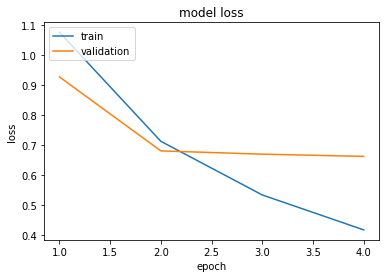

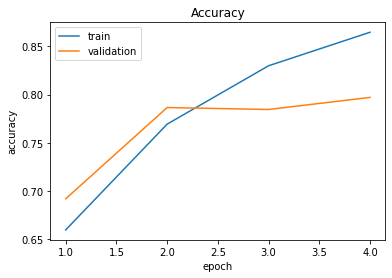

UnboundLocalError: ignored

In [ ]:
save_path = '/content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_multi.h5'
LSTM_multi(save_path)

In [ ]:
X_final,y_final = returnXY_mult()
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, shuffle=True, stratify=y_final)

loaded_model = load_model(save_path)

predictions = loaded_model.predict(X_test)
labels = ['mental', 'nonmental']
    # 예측값과 참값 
pred_labels = np.argmax(predictions, axis=1)
y_ = []
for i in y_test:
    if i[0] == 1:
        y_.append(0)
    else:
        y_.append(1)
true_labels = y_
# 예측값과 참값 
pred_labels = np.argmax(predictions, axis=1)
y_ = []
for i in y_test:
    if i[0] == 1:
        y_.append(0)
    elif i[1] == 1:
        y_.append(1)
    elif i[2] == 1:
        y_.append(2)
    elif i[3] == 1:
        y_.append(3)
    elif i[4] == 1:
        y_.append(4)
    elif i[5] == 1:
        y_.append(5)
    elif i[6] == 1:
        y_.append(6)
    elif i[6] == 1:
        y_.append(7)
    elif i[8] == 1:
        y_.append(8)
    else:
        y_.append(9)
true_labels = y_
    # #메인 실행 
    
    # confusion_matrix = confusion_matrix(true_labels, pred_labels)
    # plot_confusion_matrix(confusion_matrix, labels=labels, normalize=True)

    # y_pred = model.predict(X_practice)
    # result = []
    # for i in range(len(y_pred)):
    #     if np.argmax(y_pred[i]) == 0:
    #         result.append("슬픔")
    #     elif np.argmax(y_pred[i]) == 1:
    #         result.append("두렵")
    #     elif np.argmax(y_pred[i]) == 2:
    #         result.append("행복")
    #     else:
    #         result.append("분노")

    #precision
print("--> precision_score : ", precision_score(true_labels, pred_labels, average="weighted"))

    #recall

print("--> recall_score : ", recall_score(true_labels, pred_labels, average="weighted"))

    #f1scord

print("---> f1_score : ", f1_score(true_labels, pred_labels, average="weighted"))



depression --> 0
39261
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.2017 - acc: 0.9277
Epoch 1: val_acc improved from -inf to 0.95833, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_depression.h5
1800/1800 [==============================] - 281s 155ms/step - loss: 0.2017 - acc: 0.9277 - val_loss: 0.1126 - val_acc: 0.9583
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0877 - acc: 0.9667
Epoch 2: val_acc improved from 0.95833 to 0.97042, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_depression.h5
1800/1800 [==============================] - 270s 150ms/step - loss: 0.0877 - acc: 0.9667 - val_loss: 0.0742 - val_acc: 0.9704
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0437 - acc: 0.9843
Epoch 3: val_acc did not improve from 0.97042
1800/1800 [==============================] - 276s 154ms/step - loss: 0.0437 - acc: 0.9843 - v

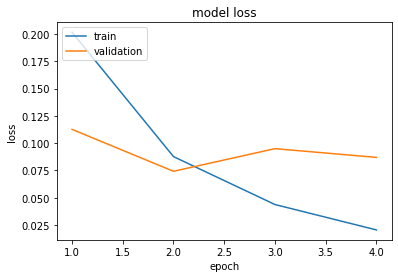

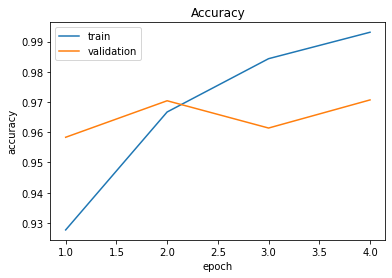

depression
--> precision_score :  0.9709010695033956
--> recall_score :  0.9706944444444444
---> f1_score :  0.9707935248479753
bipolar --> 1
39164
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1977 - acc: 0.9383
Epoch 1: val_acc improved from -inf to 0.97153, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_bipolar.h5
1800/1800 [==============================] - 270s 149ms/step - loss: 0.1977 - acc: 0.9383 - val_loss: 0.1051 - val_acc: 0.9715
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0907 - acc: 0.9752
Epoch 2: val_acc improved from 0.97153 to 0.97556, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_bipolar.h5
1800/1800 [==============================] - 266s 148ms/step - loss: 0.0907 - acc: 0.9752 - val_loss: 0.0936 - val_acc: 0.9756
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0532 - acc: 0.9845
Epoch 3: val_acc imp

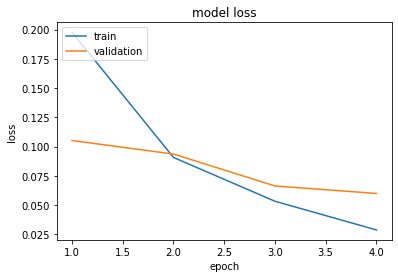

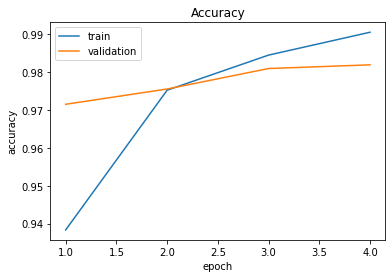

bipolar
--> precision_score :  0.9817422853623825
--> recall_score :  0.9819444444444444
---> f1_score :  0.9812081416843564
panic --> 2
38150
# int_encoding done
Epoch 1/15
1688/1688 [==============================] - ETA: 0s - loss: 0.1001 - acc: 0.9781
Epoch 1: val_acc improved from -inf to 0.98119, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_panic.h5
1688/1688 [==============================] - 251s 147ms/step - loss: 0.1001 - acc: 0.9781 - val_loss: 0.0926 - val_acc: 0.9812
Epoch 2/15
1688/1688 [==============================] - ETA: 0s - loss: 0.0488 - acc: 0.9868
Epoch 2: val_acc did not improve from 0.98119
1688/1688 [==============================] - 242s 143ms/step - loss: 0.0488 - acc: 0.9868 - val_loss: 0.0859 - val_acc: 0.9812
Epoch 3/15
1688/1688 [==============================] - ETA: 0s - loss: 0.0268 - acc: 0.9926
Epoch 3: val_acc improved from 0.98119 to 0.99067, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoi

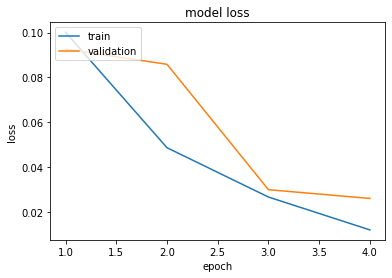

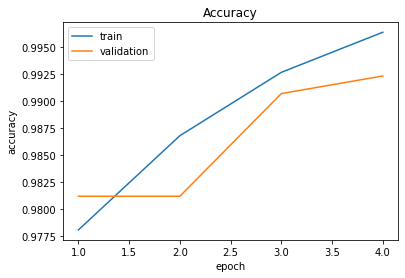

panic
--> precision_score :  0.9919222900866611
--> recall_score :  0.9922985781990521
---> f1_score :  0.9919160772534509
healthanxiety --> 3
38909
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1818 - acc: 0.9377
Epoch 1: val_acc improved from -inf to 0.95153, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_healthanxiety.h5
1800/1800 [==============================] - 274s 151ms/step - loss: 0.1818 - acc: 0.9377 - val_loss: 0.1174 - val_acc: 0.9515
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0890 - acc: 0.9693
Epoch 2: val_acc improved from 0.95153 to 0.97042, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_healthanxiety.h5
1800/1800 [==============================] - 274s 152ms/step - loss: 0.0890 - acc: 0.9693 - val_loss: 0.0907 - val_acc: 0.9704
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0529 - acc: 0.9818
Epoch 3

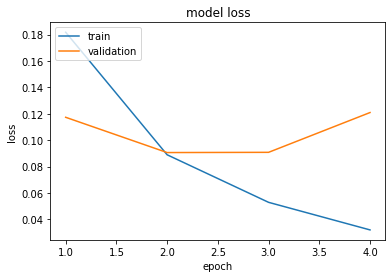

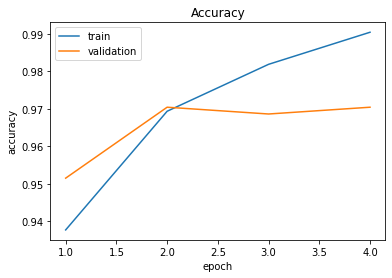

healthanxiety
--> precision_score :  0.969375824301131
--> recall_score :  0.9704166666666667
---> f1_score :  0.9696673368907531
lonely --> 4
38445
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1734 - acc: 0.9406
Epoch 1: val_acc improved from -inf to 0.96139, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_lonely.h5
1800/1800 [==============================] - 267s 148ms/step - loss: 0.1734 - acc: 0.9406 - val_loss: 0.1199 - val_acc: 0.9614
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0863 - acc: 0.9694
Epoch 2: val_acc improved from 0.96139 to 0.96292, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_lonely.h5
1800/1800 [==============================] - 274s 152ms/step - loss: 0.0863 - acc: 0.9694 - val_loss: 0.1228 - val_acc: 0.9629
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0540 - acc: 0.9808
Epoch 3: val_acc impr

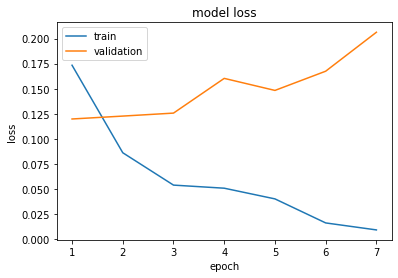

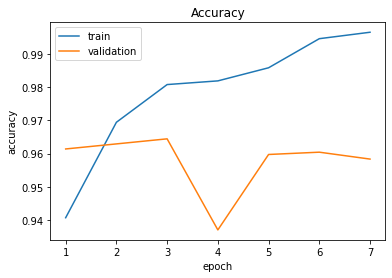

lonely
--> precision_score :  0.9625431374215361
--> recall_score :  0.9644444444444444
---> f1_score :  0.9625611534021771
socialanxiety --> 5
38628
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.2114 - acc: 0.9296
Epoch 1: val_acc improved from -inf to 0.93292, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_socialanxiety.h5
1800/1800 [==============================] - 285s 158ms/step - loss: 0.2114 - acc: 0.9296 - val_loss: 0.1508 - val_acc: 0.9329
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1025 - acc: 0.9623
Epoch 2: val_acc improved from 0.93292 to 0.96583, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_socialanxiety.h5
1800/1800 [==============================] - 280s 156ms/step - loss: 0.1025 - acc: 0.9623 - val_loss: 0.1000 - val_acc: 0.9658
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0585 - acc: 0.9794
Epoch 

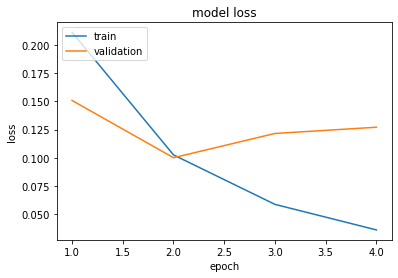

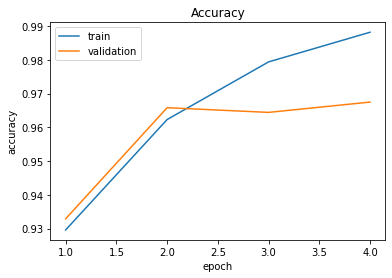

socialanxiety
--> precision_score :  0.9663148032619117
--> recall_score :  0.9675
---> f1_score :  0.9666906438019857
SuicideWatch --> 6
38555
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1915 - acc: 0.9364
Epoch 1: val_acc improved from -inf to 0.96375, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_SuicideWatch.h5
1800/1800 [==============================] - 269s 149ms/step - loss: 0.1915 - acc: 0.9364 - val_loss: 0.1015 - val_acc: 0.9638
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0791 - acc: 0.9727
Epoch 2: val_acc improved from 0.96375 to 0.96958, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_SuicideWatch.h5
1800/1800 [==============================] - 266s 148ms/step - loss: 0.0791 - acc: 0.9727 - val_loss: 0.0876 - val_acc: 0.9696
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0443 - acc: 0.9846
Epoch 3: val_a

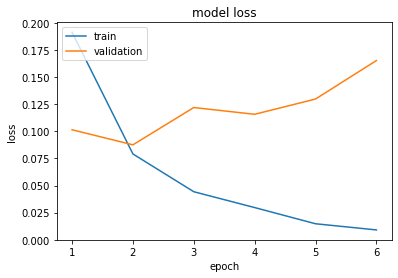

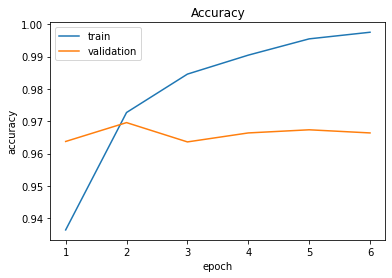

SuicideWatch
--> precision_score :  0.9684975479530501
--> recall_score :  0.9695833333333334
---> f1_score :  0.968812895676408
mentalhealth --> 7
39011
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.2324 - acc: 0.9211
Epoch 1: val_acc improved from -inf to 0.93097, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_mentalhealth.h5
1800/1800 [==============================] - 274s 152ms/step - loss: 0.2324 - acc: 0.9211 - val_loss: 0.1688 - val_acc: 0.9310
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1270 - acc: 0.9519
Epoch 2: val_acc improved from 0.93097 to 0.94611, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_mentalhealth.h5
1800/1800 [==============================] - 268s 149ms/step - loss: 0.1270 - acc: 0.9519 - val_loss: 0.1648 - val_acc: 0.9461
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0874 - acc: 0.9674
Epoc

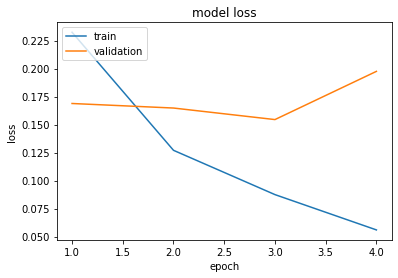

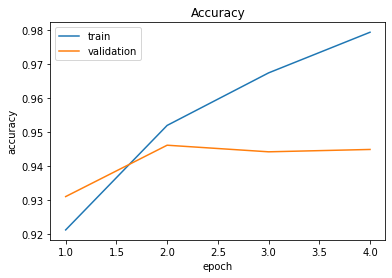

mentalhealth
--> precision_score :  0.9409883706057209
--> recall_score :  0.9461111111111111
---> f1_score :  0.9392479678067396


In [ ]:
for i in range(len(MENTAL)):
  save_path = '/content/drive/Shareddrives/SWC_Capstone/model_checkpoint/lstm_'+MENTAL[i]+'.h5'
  LSTM_binary(MENTAL[i],save_path)

##(2) Bi LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM,  Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score , recall_score , confusion_matrix, plot_confusion_matrix, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
def biLSTM_binary(df_name,save_path):
    X_final,y_final = returnXY(df_name)
    print(df_name, '-->', MENTAL.index(df_name))
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, shuffle=True, stratify=y_final)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    count = 0
    for word, word_count in tokenizer.word_counts.items():
        if word_count > 1:
            count += 1
    print(count)

    vocab_size = count #####
    tokenizer = Tokenizer(vocab_size)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    print("# int_encoding done")
    max_len = 100
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)

    embedding_dim = 100
    hidden_units = 50
    num_classes = 2

    # 모델 구축
    # 레이어들을 쌓을 모델을 생성
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(Bidirectional(LSTM(hidden_units)))
    model.add(Dense(num_classes, activation='softmax'))
    # model.add(Dropout(0.3))
    # model.add(Dense(num_classes, activation='sigmoid'))

    early_stop = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=3)
    model_check = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=16, callbacks=[early_stop, model_check])

    loaded_model = load_model(save_path)
    print("테스트 정확도 : %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

    epochs = range(1, len(hist.history['acc']) + 1)
    plt.plot(epochs, hist.history['loss'])
    plt.plot(epochs, hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(epochs, hist.history['acc'])
    plt.plot(epochs, hist.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


    predictions = loaded_model.predict(X_test)
    labels = ['mental', 'nonmental']
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        else:
            y_.append(1)
    true_labels = y_

    #precision
    print(df_name)
    print("--> precision_score : ", precision_score(true_labels, pred_labels, average="weighted"))

    #recall

    print("--> recall_score : ", recall_score(true_labels, pred_labels, average="weighted"))

    #f1scord

    print("---> f1_score : ", f1_score(true_labels, pred_labels, average="weighted"))


depression --> 0
39261
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1430 - acc: 0.9486
Epoch 1: val_acc improved from -inf to 0.95889, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_depression.h5
1800/1800 [==============================] - 219s 120ms/step - loss: 0.1430 - acc: 0.9486 - val_loss: 0.1049 - val_acc: 0.9589
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0718 - acc: 0.9743
Epoch 2: val_acc improved from 0.95889 to 0.96875, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_depression.h5
1800/1800 [==============================] - 213s 118ms/step - loss: 0.0718 - acc: 0.9743 - val_loss: 0.0958 - val_acc: 0.9688
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0418 - acc: 0.9849
Epoch 3: val_acc did not improve from 0.96875
1800/1800 [==============================] - 235s 130ms/step - loss: 0.0418 - acc: 0.9849

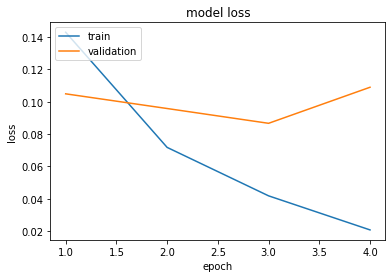

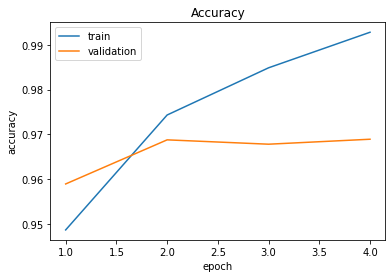

depression
--> precision_score :  0.968661589613409
--> recall_score :  0.9688888888888889
---> f1_score :  0.968769945525523
bipolar --> 1
39164
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1219 - acc: 0.9610
Epoch 1: val_acc improved from -inf to 0.98222, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_bipolar.h5
1800/1800 [==============================] - 211s 115ms/step - loss: 0.1219 - acc: 0.9610 - val_loss: 0.0588 - val_acc: 0.9822
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0494 - acc: 0.9844
Epoch 2: val_acc did not improve from 0.98222
1800/1800 [==============================] - 210s 117ms/step - loss: 0.0494 - acc: 0.9844 - val_loss: 0.0701 - val_acc: 0.9750
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0284 - acc: 0.9908
Epoch 3: val_acc did not improve from 0.98222
1800/1800 [==============================] - 211s 117ms/step - loss: 

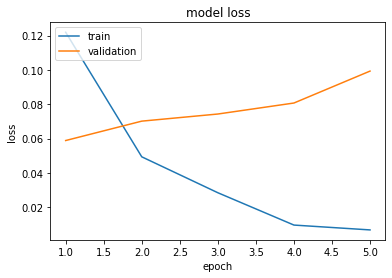

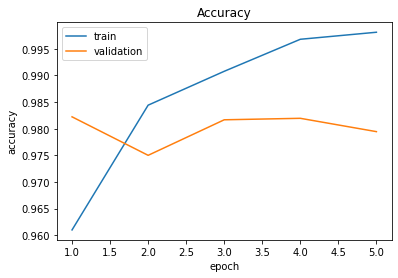

bipolar
--> precision_score :  0.9818168256813227
--> recall_score :  0.9822222222222222
---> f1_score :  0.981779497464334
panic --> 2
38150
# int_encoding done
Epoch 1/15
1688/1688 [==============================] - ETA: 0s - loss: 0.0722 - acc: 0.9832
Epoch 1: val_acc improved from -inf to 0.98682, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_panic.h5
1688/1688 [==============================] - 195s 113ms/step - loss: 0.0722 - acc: 0.9832 - val_loss: 0.0506 - val_acc: 0.9868
Epoch 2/15
1688/1688 [==============================] - ETA: 0s - loss: 0.0338 - acc: 0.9908
Epoch 2: val_acc improved from 0.98682 to 0.99230, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_panic.h5
1688/1688 [==============================] - 191s 113ms/step - loss: 0.0338 - acc: 0.9908 - val_loss: 0.0309 - val_acc: 0.9923
Epoch 3/15
1688/1688 [==============================] - ETA: 0s - loss: 0.0216 - acc: 0.9936
Epoch 3: val_acc did not i

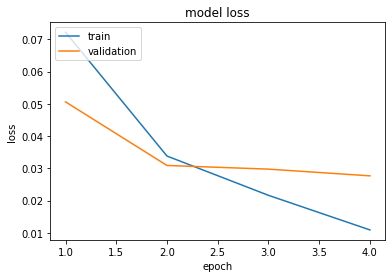

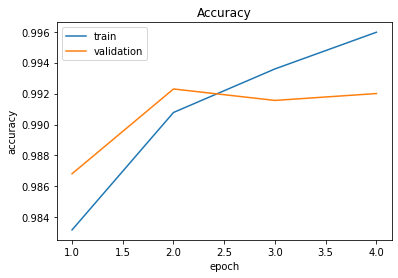

panic
--> precision_score :  0.9919336473834556
--> recall_score :  0.9922985781990521
---> f1_score :  0.9918548658682487
healthanxiety --> 3
38909
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1424 - acc: 0.9496
Epoch 1: val_acc improved from -inf to 0.97069, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_healthanxiety.h5
1800/1800 [==============================] - 225s 123ms/step - loss: 0.1424 - acc: 0.9496 - val_loss: 0.0937 - val_acc: 0.9707
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0639 - acc: 0.9793
Epoch 2: val_acc improved from 0.97069 to 0.97403, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_healthanxiety.h5
1800/1800 [==============================] - 208s 116ms/step - loss: 0.0639 - acc: 0.9793 - val_loss: 0.0891 - val_acc: 0.9740
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0389 - acc: 0.9882
Epo

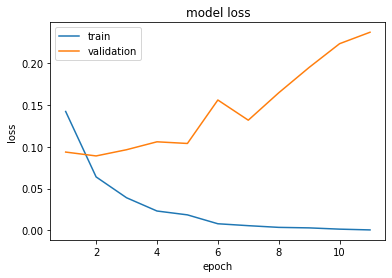

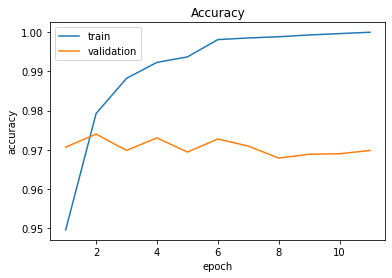

healthanxiety
--> precision_score :  0.9732771603431999
--> recall_score :  0.9740277777777778
---> f1_score :  0.9735013512617963
lonely --> 4
38445
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1792 - acc: 0.9394
Epoch 1: val_acc improved from -inf to 0.95514, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_lonely.h5
1800/1800 [==============================] - 218s 119ms/step - loss: 0.1792 - acc: 0.9394 - val_loss: 0.1226 - val_acc: 0.9551
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0959 - acc: 0.9652
Epoch 2: val_acc improved from 0.95514 to 0.96250, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_lonely.h5
1800/1800 [==============================] - 211s 117ms/step - loss: 0.0959 - acc: 0.9652 - val_loss: 0.1144 - val_acc: 0.9625
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0521 - acc: 0.9810
Epoch 3: val_acc

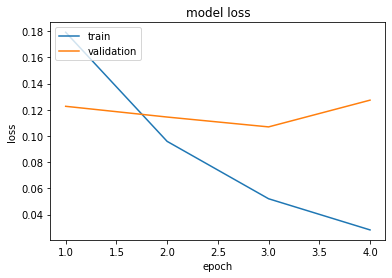

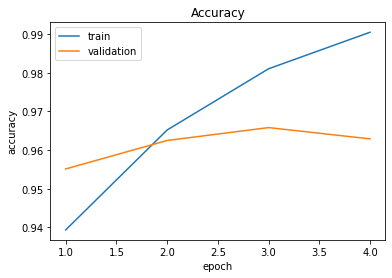

lonely
--> precision_score :  0.9642708324846272
--> recall_score :  0.9658333333333333
---> f1_score :  0.9646250923273131
socialanxiety --> 5
38628
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1844 - acc: 0.9338
Epoch 1: val_acc improved from -inf to 0.96500, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_socialanxiety.h5
1800/1800 [==============================] - 214s 117ms/step - loss: 0.1844 - acc: 0.9338 - val_loss: 0.1062 - val_acc: 0.9650
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0860 - acc: 0.9707
Epoch 2: val_acc improved from 0.96500 to 0.96681, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_socialanxiety.h5
1800/1800 [==============================] - 211s 117ms/step - loss: 0.0860 - acc: 0.9707 - val_loss: 0.0925 - val_acc: 0.9668
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0509 - acc: 0.9826
Ep

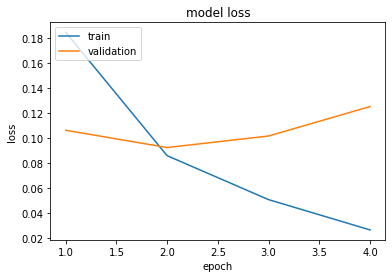

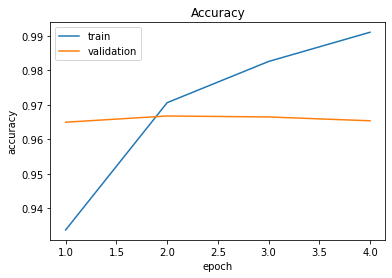

socialanxiety
--> precision_score :  0.9667308347482275
--> recall_score :  0.9668055555555556
---> f1_score :  0.9667677297462395
SuicideWatch --> 6
38555
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1442 - acc: 0.9507
Epoch 1: val_acc improved from -inf to 0.95042, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_SuicideWatch.h5
1800/1800 [==============================] - 210s 115ms/step - loss: 0.1442 - acc: 0.9507 - val_loss: 0.1329 - val_acc: 0.9504
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0671 - acc: 0.9770
Epoch 2: val_acc improved from 0.95042 to 0.96486, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_SuicideWatch.h5
1800/1800 [==============================] - 207s 115ms/step - loss: 0.0671 - acc: 0.9770 - val_loss: 0.1072 - val_acc: 0.9649
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0373 - acc: 0.987

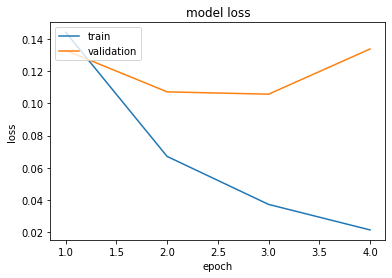

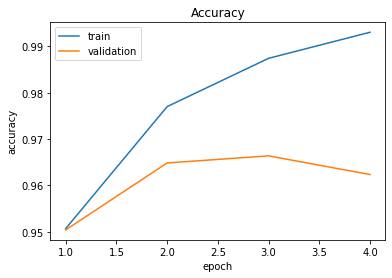

SuicideWatch
--> precision_score :  0.9647375297545462
--> recall_score :  0.9663888888888889
---> f1_score :  0.9648631851066477
mentalhealth --> 7
39011
# int_encoding done
Epoch 1/15
1800/1800 [==============================] - ETA: 0s - loss: 0.2121 - acc: 0.9278
Epoch 1: val_acc improved from -inf to 0.94111, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_mentalhealth.h5
1800/1800 [==============================] - 213s 117ms/step - loss: 0.2121 - acc: 0.9278 - val_loss: 0.1591 - val_acc: 0.9411
Epoch 2/15
1800/1800 [==============================] - ETA: 0s - loss: 0.1106 - acc: 0.9593
Epoch 2: val_acc improved from 0.94111 to 0.94528, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_mentalhealth.h5
1800/1800 [==============================] - 209s 116ms/step - loss: 0.1106 - acc: 0.9593 - val_loss: 0.1481 - val_acc: 0.9453
Epoch 3/15
1800/1800 [==============================] - ETA: 0s - loss: 0.0603 - acc: 0.9784

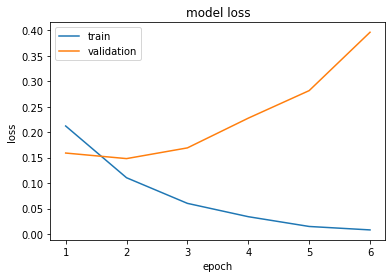

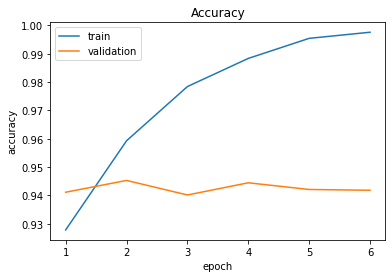

mentalhealth
--> precision_score :  0.9413157323742172
--> recall_score :  0.9452777777777778
---> f1_score :  0.9426398941448527


In [ ]:
for i in range(len(MENTAL)):
  save_path = '/content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_'+MENTAL[i]+'.h5'
  biLSTM_binary(MENTAL[i],save_path)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding, Dropout


def biLSTM_multi(save_path,):
    X_final,y_final = returnXY_mult()
    # print(df_name, '-->', MENTAL.index(df_name))
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, shuffle=True, stratify=y_final)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    count = 0

    for word, word_count in tokenizer.word_counts.items():
        if word_count > 1:
            count += 1
    print(count)

    vocab_size = count #####
    tokenizer = Tokenizer(vocab_size)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    print("# int_encoding done")
    max_len = 100
    X_train = pad_sequences(X_train, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)

    # 모델 구축
    # 레이어들을 쌓을 모델을 생성
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(Bidirectional(LSTM(hidden_units)))
    model.add(Dense(num_classes, activation='softmax'))

    # from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

    early_stop = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=3)
    model_check = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch, batch_size=16, callbacks=[early_stop, model_check])

    loaded_model = load_model(save_path)
    print("테스트 정확도 : %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

    epochs = range(1, len(hist.history['acc']) + 1)
    plt.plot(epochs, hist.history['loss'])
    plt.plot(epochs, hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(epochs, hist.history['acc'])
    plt.plot(epochs, hist.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = loaded_model.predict(X_test)
    labels = ['mental', 'nonmental']
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        else:
            y_.append(1)
    true_labels = y_
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        elif i[1] == 1:
            y_.append(1)
        elif i[2] == 1:
            y_.append(2)
        elif i[3] == 1:
            y_.append(3)
        elif i[4] == 1:
            y_.append(4)
        elif i[5] == 1:
            y_.append(5)
        elif i[6] == 1:
            y_.append(6)
        elif i[6] == 1:
            y_.append(7)
        elif i[8] == 1:
            y_.append(8)
        else:
            y_.append(9)
    true_labels = y_
    #메인 실행 
    confusion_matrix = confusion_matrix(true_labels, pred_labels)
    plot_confusion_matrix(confusion_matrix, labels=labels, normalize=True)

    #precision
    print("--> precision_score : ", precision_score(true_labels, pred_labels, average="weighted"))

    #recall

    print("--> recall_score : ", recall_score(true_labels, pred_labels, average="weighted"))

    #f1scord

    print("---> f1_score : ", f1_score(true_labels, pred_labels, average="weighted"))



In [ ]:
save_path = '/content/drive/Shareddrives/SWC_Capstone/model_checkpoint/bilstm_multi.h5'
biLSTM_multi(save_path,1)

# 2. 점수 학습 모델 - SVM

In [ ]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

In [ ]:
def returnXY_svm(df_name):
    if df_name in NONMENTAL:
        print('wrong df. put mental health data')
        return
    
    index = MENTAL.index(df_name)

    temp = pd.concat([SNM_DF,SM_DF[index]])
    temp.reset_index(inplace=True, drop=True)


    X = temp[temp.columns[:-1]].values

    y = temp['label'].values

    return X, y #temp_y

def returnXY_svm_select_col(df_name, column_list):
    if df_name in NONMENTAL:
        print('wrong df. put mental health data')
        return
    
    index = MENTAL.index(df_name)

    temp = pd.concat([SNM_DF[column_list],SM_DF[index][column_list]])
    temp.reset_index(inplace=True, drop=True)


    X = temp[temp.columns[:-1]].values

    y = temp['label'].values


    return X, y #temp_y

def returnXY_svm_mult():
    temp = pd.concat([df for df in SM_DF])
    temp = pd.concat([temp,SNM_DF])
    temp.reset_index(inplace=True, drop=True)

    X = temp[temp.columns[:-1]].values

    # y= pd.get_dummies(temp['label'].values).values
    y = temp['label'].values

    return X, y



In [ ]:
def svm_binary(df_name):
    X, y = returnXY_svm(df_name)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,shuffle=True, random_state = 42)

    
    clf = svm.SVC(kernel = 'rbf')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(df_name)

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",precision_score(y_test, y_pred, average="weighted"))
    print("Recall:",recall_score(y_test, y_pred, average="weighted"))
    print("F1_score:", f1_score(y_test, y_pred, average="weighted"))

for i in range(len(MENTAL)):
    svm_binary(MENTAL[i])

depression
Accuracy: 0.9395370370370371
Precision: 0.932528433783328
Recall: 0.9395370370370371
F1_score: 0.9320937615916227
bipolar
Accuracy: 0.9297222222222222
Precision: 0.9190917333737089
Recall: 0.9297222222222222
F1_score: 0.9151468677665293
panic
Accuracy: 0.9893364928909952
Precision: 0.988556508790214
Recall: 0.9893364928909952
F1_score: 0.9884203102572056
healthanxiety
Accuracy: 0.9400925925925926
Precision: 0.934273026647737
Recall: 0.9400925925925926
F1_score: 0.930255167861177
lonely
Accuracy: 0.9178703703703703
Precision: 0.8988889669163546
Recall: 0.9178703703703703
F1_score: 0.8878310765128348
socialanxiety
Accuracy: 0.9173148148148148
Precision: 0.9051214178154495
Recall: 0.9173148148148148
F1_score: 0.8830433505770152
SuicideWatch
Accuracy: 0.9307407407407408
Precision: 0.9221050565770047
Recall: 0.9307407407407408
F1_score: 0.9147977058729745
mentalhealth
Accuracy: 0.9177777777777778
Precision: 0.8979719521848862
Recall: 0.9177777777777778
F1_score: 0.888174642506258

In [ ]:
# 데이터 분리
from sklearn.preprocessing import StandardScaler

X, y = returnXY_svm('depression')
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,shuffle=True, random_state = 42)


 
clf =svm.NuSVC(gamma="auto")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred,average="weighted"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average="weighted"))

print("F1_score:", f1_score(y_test, y_pred, average="weighted"))

 
svm_clf =svm.SVC(kernel = 'rbf')
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average="weighted"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average="weighted"))

print("F1_score:", f1_score(y_test, y_pred, average="weighted"))


# # 교차검증

# scores = cross_val_score(svm_clf, X, y, cv = 5)
# scores

# pd.DataFrame(cross_validate(svm_clf, X, y, cv =5))

# print('교차검증 평균: ', scores.mean())


Accuracy: 0.45111111111111113
Precision: 0.4472066765397661
Recall: 0.45111111111111113
F1_score: 0.44360266773845425
Accuracy: 0.5257407407407407
Precision: 0.5144556590156698
Recall: 0.5257407407407407
F1_score: 0.5124969030055575


# 3. New model

문장과 점수 모두 학습 데이터로 받음

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM,  Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score , recall_score , confusion_matrix, plot_confusion_matrix, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint

import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

In [ ]:
def return_tsl(df_name):
    if df_name in NONMENTAL:
        print('wrong df. put mental health data')
        return

    index = MENTAL.index(df_name)
    
    temp_nm = pd.concat([TNM_DF[TNM_DF.columns[:-1]], SNM_DF],axis=1)
    tm_Df = TM_DF[index]
    sm_Df = SM_DF[index]
    temp_m = pd.concat([tm_Df[tm_Df.columns[:-1]],sm_Df],axis=1)

    temp = pd.concat([temp_nm,temp_m])
    
    y= pd.get_dummies(temp['label'].values).values
  
  
    return temp[temp.columns[:-1]].values,y

def return_tsl_mult():
    if df_name in NONMENTAL:
        print('wrong df. put mental health data')
        return
    
    temp_nm = pd.concat([TNM_DF[TNM_DF.columns[:-1]], SNM_DF],axis=1)
    tm_Df = pd.concat([df for df in TM_DF])
    sm_Df = pd.concat([df for df in SM_DF])
    temp_m = pd.concat([tm_Df[tm_Df.columns[:-1]],sm_Df],axis=1)

    temp = pd.concat([temp_nm,temp_m])
    temp.reset_index(drop=True, inplace=True)
    
    y= pd.get_dummies(temp['label'].values).values
  
  
    return temp[temp.columns[:-1]].values,y

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from sklearn.svm import SVC

def concatenate_binary(df_name,save_path):
    
    ## 학습 데이터셋 
    X, y = return_tsl(df_name)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
    # print(X_train)
    X_train = np.split(X_train,[1],axis=1)
    # print(X_train)
    X_test = np.split(X_test,[1],axis=1)

    text_train = np.array([item[0] for item in X_train[0]])#.astype(str)
    score_train = X_train[1].astype(float) #[item[0] for item in X_train[1]]
    # print(score_train)
    text_test = np.array([item[0] for item in X_test[0]])#.astype(str)
    score_test = X_test[1].astype(float) #[item[0] for item in X_test[1]]

    scaler = StandardScaler()
    # # 메소드체이닝(chaining)을 사용하여 fit과 transform을 연달아 호출합니다
    # X_scaled = scaler.fit(score_train).transform(score_train)

    # 위와 동일하지만 더 효율적입니다(fit_transform)
    score_train = scaler.fit_transform(score_train)

    #해당 fit으로 test데이터도 transform 해줍니다
    score_test = scaler.transform(score_test)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_train)
    count = 0
    for word, word_count in tokenizer.word_counts.items():
        if word_count > 1:
            count += 1
    print(count)

    vocab_size = count #####
    tokenizer = Tokenizer(vocab_size)
    tokenizer.fit_on_texts(text_train)

    text_train = tokenizer.texts_to_sequences(text_train)
    text_test = tokenizer.texts_to_sequences(text_test)

    print("# int_encoding done")
    max_len = 100
    text_train = pad_sequences(text_train, maxlen=max_len)
    text_test = pad_sequences(text_test, maxlen=max_len)

    embedding_dim = 100
    hidden_units = 128
    num_classes = 2   

    # 두 개의 입력층을 정의
    inputA = Input(shape=(None,))
    inputB = Input(shape=(22,))

    # 첫번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
    x = Embedding(vocab_size, embedding_dim)(inputA)
    x = Bidirectional(LSTM(hidden_units))(x)
    x = Dense(16, activation='relu')(x)
    x = Model(inputs=inputA, outputs=x)

    # 두번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
    # y = svm.SVC(kernel='rbf')(inputB)
    y = Dense(22, activation="relu")(inputB)
    y = Dense(16, activation="relu")(y)
    y = Dense(8, activation="relu")(y)
    y = Dense(8, activation="relu")(y)
    y = Model(inputs=inputB, outputs=y)

    # 두개의 인공 신경망의 출력을 연결(concatenate)
    result = concatenate([x.output, y.output])

    z = Dense(16, activation="relu")(result)
    z = Dense(num_classes, activation="softmax")(z)

    model = Model(inputs=[x.input, y.input], outputs=z)

    early_stop = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=3)
    model_check = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    optimizer = tf.keras.optimizers.Adam(clipvalue=1,lr=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    hist = model.fit([text_train, score_train], y_train, validation_data=([text_test, score_test], y_test), epochs=10, batch_size=16, callbacks=[early_stop, model_check])

    # loaded_model = load_model(save_path)

    predictions = model.predict([text_test,score_test])
    labels = ['mental', 'nonmental']
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        else:
            y_.append(1)
    true_labels = y_

    #precision
    print(df_name)
    print("--> precision_score : ", precision_score(true_labels, pred_labels, average="weighted"))

    #recall

    print("--> recall_score : ", recall_score(true_labels, pred_labels, average="weighted"))

    #f1scord

    print("--> f1_score : ", f1_score(true_labels, pred_labels, average="weighted"))

# save_path = '/content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_bipolar.h5'
# concatenate_binary('bipolar',save_path)

In [ ]:
for i in range(1,len(MENTAL)):
    save_path = '/content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_'+MENTAL[i]+'.h5'
    concatenate_binary(MENTAL[i],save_path)

38457
# int_encoding done
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1800/1800 [==============================] - ETA: 0s - loss: 0.1347 - acc: 0.9495
Epoch 1: val_acc improved from -inf to 0.96417, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_bipolar.h5
1800/1800 [==============================] - 390s 206ms/step - loss: 0.1347 - acc: 0.9495 - val_loss: 0.0981 - val_acc: 0.9642
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0554 - acc: 0.9808
Epoch 2: val_acc improved from 0.96417 to 0.97694, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_bipolar.h5
1800/1800 [==============================] - 360s 200ms/step - loss: 0.0554 - acc: 0.9808 - val_loss: 0.0616 - val_acc: 0.9769
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0270 - acc: 0.9915
Epoch 3: val_acc improved from 0.97694 to 0.98278, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_bipolar.h5
1800/1800 [=============================

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1688/1688 [==============================] - ETA: 0s - loss: 0.0384 - acc: 0.9880
Epoch 1: val_acc improved from -inf to 0.99304, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_panic.h5
1688/1688 [==============================] - 361s 212ms/step - loss: 0.0384 - acc: 0.9880 - val_loss: 0.0196 - val_acc: 0.9930
Epoch 2/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0142 - acc: 0.9953
Epoch 2: val_acc improved from 0.99304 to 0.99467, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_panic.h5
1688/1688 [==============================] - 328s 194ms/step - loss: 0.0142 - acc: 0.9953 - val_loss: 0.0133 - val_acc: 0.9947
Epoch 3/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0073 - acc: 0.9977
Epoch 3: val_acc improved from 0.99467 to 0.99615, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_panic.h5
1688/1688 [==============================] - 3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1800/1800 [==============================] - ETA: 0s - loss: 0.1273 - acc: 0.9551
Epoch 1: val_acc improved from -inf to 0.96889, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_healthanxiety.h5
1800/1800 [==============================] - 376s 207ms/step - loss: 0.1273 - acc: 0.9551 - val_loss: 0.0875 - val_acc: 0.9689
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0792 - acc: 0.9706
Epoch 2: val_acc did not improve from 0.96889
1800/1800 [==============================] - 368s 205ms/step - loss: 0.0792 - acc: 0.9706 - val_loss: 0.1114 - val_acc: 0.9600
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0467 - acc: 0.9832
Epoch 3: val_acc improved from 0.96889 to 0.97792, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_healthanxiety.h5
1800/1800 [==============================] - 378s 210ms/step - loss: 0.0467 - acc: 0.9832 - val_loss: 0.0716 - val_acc: 0.9779
Ep

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1800/1800 [==============================] - ETA: 0s - loss: 0.1826 - acc: 0.9344
Epoch 1: val_acc improved from -inf to 0.95792, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_lonely.h5
1800/1800 [==============================] - 365s 201ms/step - loss: 0.1826 - acc: 0.9344 - val_loss: 0.1137 - val_acc: 0.9579
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0987 - acc: 0.9634
Epoch 2: val_acc improved from 0.95792 to 0.96125, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_lonely.h5
1800/1800 [==============================] - 360s 200ms/step - loss: 0.0987 - acc: 0.9634 - val_loss: 0.0967 - val_acc: 0.9613
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0555 - acc: 0.9792
Epoch 3: val_acc improved from 0.96125 to 0.96972, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_lonely.h5
1800/1800 [==============================] 

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1800/1800 [==============================] - ETA: 0s - loss: 0.2259 - acc: 0.9232
Epoch 1: val_acc improved from -inf to 0.94292, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_socialanxiety.h5
1800/1800 [==============================] - 362s 197ms/step - loss: 0.2259 - acc: 0.9232 - val_loss: 0.1495 - val_acc: 0.9429
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 0.1069 - acc: 0.9607
Epoch 2: val_acc improved from 0.94292 to 0.96375, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_socialanxiety.h5
1800/1800 [==============================] - 357s 198ms/step - loss: 0.1069 - acc: 0.9607 - val_loss: 0.0932 - val_acc: 0.9638
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0567 - acc: 0.9799
Epoch 3: val_acc improved from 0.96375 to 0.96667, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_socialanxiety.h5
1800/1800 [===========

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1800/1800 [==============================] - ETA: 0s - loss: 0.1177 - acc: 0.9590
Epoch 1: val_acc improved from -inf to 0.97125, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_SuicideWatch.h5
1800/1800 [==============================] - 364s 200ms/step - loss: 0.1177 - acc: 0.9590 - val_loss: 0.0752 - val_acc: 0.9712
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0528 - acc: 0.9825
Epoch 2: val_acc did not improve from 0.97125
1800/1800 [==============================] - 357s 199ms/step - loss: 0.0528 - acc: 0.9825 - val_loss: 0.0801 - val_acc: 0.9706
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0299 - acc: 0.9891
Epoch 3: val_acc did not improve from 0.97125
1800/1800 [==============================] - 351s 195ms/step - loss: 0.0299 - acc: 0.9891 - val_loss: 0.0986 - val_acc: 0.9678
Epoch 4/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0186 - acc: 0.9940
Epoch 4: val_acc 

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1800/1800 [==============================] - ETA: 0s - loss: 0.2161 - acc: 0.9205
Epoch 1: val_acc improved from -inf to 0.93264, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_mentalhealth.h5
1800/1800 [==============================] - 359s 198ms/step - loss: 0.2161 - acc: 0.9205 - val_loss: 0.2142 - val_acc: 0.9326
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 0.1149 - acc: 0.9564
Epoch 2: val_acc improved from 0.93264 to 0.95056, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_mentalhealth.h5
1800/1800 [==============================] - 353s 196ms/step - loss: 0.1149 - acc: 0.9564 - val_loss: 0.1186 - val_acc: 0.9506
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 0.0696 - acc: 0.9739
Epoch 3: val_acc improved from 0.95056 to 0.95333, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_binary_mentalhealth.h5
1800/1800 [==============

In [ ]:
def return_tsl_mult():
    temp_nm = pd.concat([TNM_DF[TNM_DF.columns[:-1]], SNM_DF],axis=1)
    tm_Df = pd.concat([df for df in TM_DF])
    sm_Df = pd.concat([df for df in SM_DF])
    temp_m = pd.concat([tm_Df[tm_Df.columns[:-1]],sm_Df],axis=1)

    temp = pd.concat([temp_nm,temp_m])
    temp.reset_index(drop=True, inplace=True)
    
    y= pd.get_dummies(temp['label'].values).values
  
  
    return temp[temp.columns[:-1]].values,y

In [ ]:
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
from sklearn.svm import SVC

def concatenate_multi(save_path,epoch):
    
    # 학습 데이터셋 
    X, y = return_tsl_mult()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

    X_train = np.split(X_train,[1],axis=1)
    X_test = np.split(X_test,[1],axis=1)

    text_train = np.array([item[0] for item in X_train[0]])#.astype(str)
    score_train = X_train[1].astype(float) 
    text_test = np.array([item[0] for item in X_test[0]])#.astype(str)
    score_test = X_test[1].astype(float) 

    scaler = StandardScaler()

    score_train = scaler.fit_transform(score_train)
    score_test = scaler.transform(score_test)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_train)
    count = 0
    for word, word_count in tokenizer.word_counts.items():
        if word_count > 1:
            count += 1
    print(count)

    vocab_size = count 
    tokenizer = Tokenizer(vocab_size)
    tokenizer.fit_on_texts(text_train)

    text_train = tokenizer.texts_to_sequences(text_train)
    text_test = tokenizer.texts_to_sequences(text_test)

    print("# int_encoding done")
    max_len = 100
    text_train = pad_sequences(text_train, maxlen=max_len)
    text_test = pad_sequences(text_test, maxlen=max_len)

    embedding_dim = 100
    hidden_units = 128
    num_classes = 9  

    # 두 개의 입력층을 정의
    inputA = Input(shape=(None,))
    inputB = Input(shape=(22,))

    # 문장 데이터 학습
    x = Embedding(vocab_size, embedding_dim)(inputA)
    x = Bidirectional(LSTM(hidden_units))(x)
    x = Dense(16, activation='relu')(x)
    x = Model(inputs=inputA, outputs=x)

    # 점수 데이터 학습
    y = Dense(22, activation="relu")(inputB)
    y = Dense(16, activation="relu")(y)
    y = Dense(8, activation="relu")(y)
    y = Dense(8, activation="relu")(y)
    y = Dense(8, activation="relu")(y)
    y = Model(inputs=inputB, outputs=y)

    # 두개 모델 연결(concatenate)
    result = concatenate([x.output, y.output])

    z = Dense(16, activation="relu")(result)
    z = Dense(12, activation="relu")(result)
    z = Dense(num_classes, activation="softmax")(z)

    model = Model(inputs=[x.input, y.input], outputs=z)

    early_stop = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=3)
    model_check = ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    optimizer = tf.keras.optimizers.Adam(clipvalue=1,lr=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    hist = model.fit([text_train, score_train], y_train, validation_data=([text_test, score_test], y_test), epochs=epoch, batch_size=16, callbacks=[early_stop, model_check])

    # loaded_model = load_model(save_path)
    

    predictions = model.predict([text_test,score_test])
    labels = ['mental', 'nonmental']
    # 예측값과 참값 
    pred_labels = np.argmax(predictions, axis=1)
    y_ = []
    for i in y_test:
        if i[0] == 1:
            y_.append(0)
        elif i[1] == 1:
            y_.append(1)
        elif i[2] == 1:
            y_.append(2)
        elif i[3] == 1:
            y_.append(3)
        elif i[4] == 1:
            y_.append(4)
        elif i[5] == 1:
            y_.append(5)
        elif i[6] == 1:
            y_.append(6)
        elif i[7] == 1:
            y_.append(7)
        elif i[8] == 1:
            y_.append(8)
        else:
            y_.append(9)
    true_labels = y_

    #precision
    print("--> precision_score : ", precision_score(true_labels, pred_labels, average="weighted"))

    #recall
    print("--> recall_score : ", recall_score(true_labels, pred_labels, average="weighted"))

    #f1score
    print("--> f1_score : ", f1_score(true_labels, pred_labels, average="weighted"))


In [ ]:
concatenate_multi(save_path,20)

44549
# int_encoding done
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2738/2738 [==============================] - ETA: 0s - loss: 1.0391 - acc: 0.6528
Epoch 1: val_acc improved from -inf to 0.70836, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_multi.h5
2738/2738 [==============================] - 621s 224ms/step - loss: 1.0391 - acc: 0.6528 - val_loss: 0.8497 - val_acc: 0.7084
Epoch 2/20
2738/2738 [==============================] - ETA: 0s - loss: 0.7104 - acc: 0.7530
Epoch 2: val_acc improved from 0.70836 to 0.76470, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_multi.h5
2738/2738 [==============================] - 586s 214ms/step - loss: 0.7104 - acc: 0.7530 - val_loss: 0.6868 - val_acc: 0.7647
Epoch 3/20
2738/2738 [==============================] - ETA: 0s - loss: 0.5508 - acc: 0.8087
Epoch 3: val_acc improved from 0.76470 to 0.79447, saving model to /content/drive/Shareddrives/SWC_Capstone/model_checkpoint/con_multi.h5
2738/2738 [==============================] - 597s 218ms/step - loss

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
